In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

/Users/antonadonin/PycharmProjects/nlp/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_dataset('Davlan/sib200', 'rus_Cyrl')
df_train = pd.DataFrame(data['train'])
df_val = pd.DataFrame(data['validation'])
df_test = pd.DataFrame(data['test'])
df_list = [df_train, df_val, df_test]

In [3]:
print(df_train)

     index_id            category  \
0         431           geography   
1         403  science/technology   
2        1592  science/technology   
3         993       entertainment   
4         755       entertainment   
..        ...                 ...   
696       920  science/technology   
697      1516  science/technology   
698      1922              travel   
699         5              sports   
700       453  science/technology   

                                                  text  
0    Турция с трёх сторон окружена морями: на запад...  
1    В начале войны они в основном передвигались по...  
2    По мере того как знание греческого языка ухудш...  
3    Впрочем, зимой это другая красота и шарм, с го...  
4    В этих отелях останавливались богатые и извест...  
..                                                 ...  
696  Если у вас нет соединения для передачи данных ...  
697  Так, высказана мысль о том, что "обучение" и "...  
698  В некоторых круизных брошюрах предста

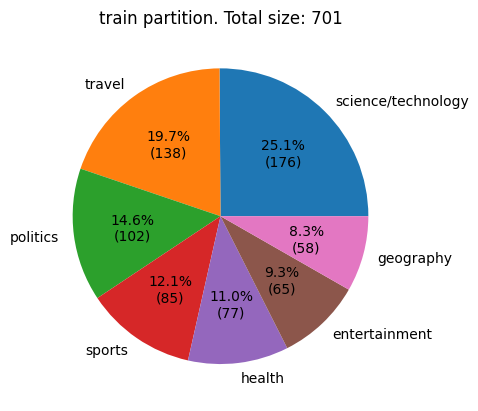

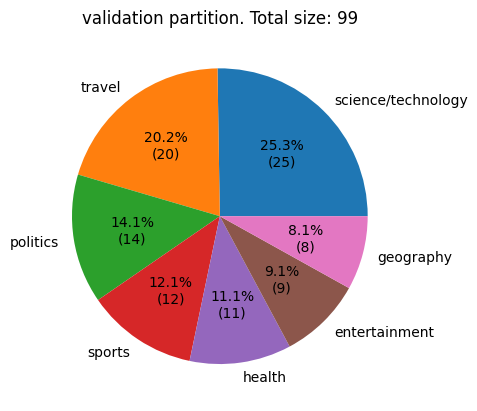

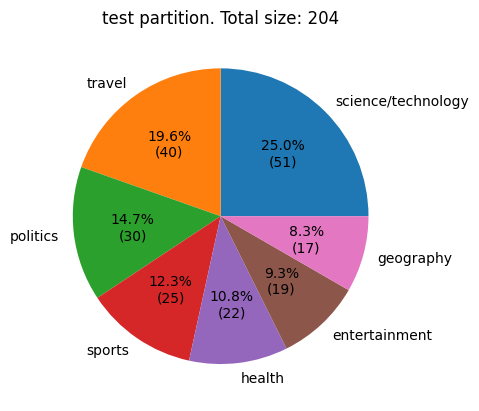

In [4]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

for part in data.keys():
    pd_series = pd.Series(data[part]['category'])
    val_counts = pd_series.value_counts()
    plt.pie(val_counts, labels=val_counts.index, autopct=autopct_format(val_counts))
    plt.title(f"{part} partition. Total size: {len(pd_series)}")
    plt.show()

In [5]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import pymorphy3
nltk.download('stopwords')
nltk.download('wordnet')
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer() 
morph = pymorphy3.MorphAnalyzer()

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', 'NUM', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('russian')]
    normalized_words = [morph.parse(w)[0].normal_form for w in filtered_words]
    return " ".join(normalized_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonadonin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antonadonin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
for df in df_list:
    df['clean_text'] = df['text'].map(lambda s:preprocess(s))


In [7]:
df_train

,index_id,category,text,clean_text
0,431,geography,Турция с трёх сторон окружена морями: на запад...,турция три сторона окружить море запад эгейски...
1,403,science/technology,В начале войны они в основном передвигались по...,начало война основное передвигаться поверхност...
2,1592,science/technology,По мере того как знание греческого языка ухудш...,мера знание греческий язык ухудшаться запад ок...
3,993,entertainment,"Впрочем, зимой это другая красота и шарм, с го...",зимой это другой красота шарм горный деревушка...
4,755,entertainment,В этих отелях останавливались богатые и извест...,этот отель останавливаться богатый известный ч...
...,...,...,...,...
696,920,science/technology,Если у вас нет соединения для передачи данных ...,соединение передача данные телефон находиться ...
697,1516,science/technology,"Так, высказана мысль о том, что ""обучение"" и ""...",высказать мысль обучение социализация являться...
698,1922,travel,В некоторых круизных брошюрах представлен Берл...,некоторый круизный брошюра представить берлин ...
699,5,sports,"28-летний Алеш Видаль перешел в ""Барсу"" из ""Се...",num летний алеш видаль перейти барс севилья се...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df_train['text'])

# Step 4: Displaying the Vocabulary and Frequency Counts
# print("Vocabulary:", vectorizer.vocabulary_)
print("Feature Names:", vectorizer.get_feature_names_out())
print(f'Length of dictionary: {len(vectorizer.vocabulary_)}')


In [ ]:
d_view = [ (v,k) for k,v in vectorizer.vocabulary_.items() ]
d_view.sort(reverse=True) # natively sort tuples by first element
for v,k in d_view:
    pass
    # print("%s: %d" % (k,v))

In [10]:
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

vectorizer = CountVectorizer()
label_encoder = LabelEncoder()
X = vectorizer.fit_transform(df_train['clean_text'])
y = label_encoder.fit_transform(df_train['category'])
clf = LogisticRegression().fit(X, y)

X_test = vectorizer.transform(df_test['clean_text'])
y_test = label_encoder.transform(df_test['category'])

y_pred = clf.predict(X_test)
acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Accuracy: {acc:.3f}\nF1M: {f1:.3f}')

Accuracy: 0.647
F1M: 0.632


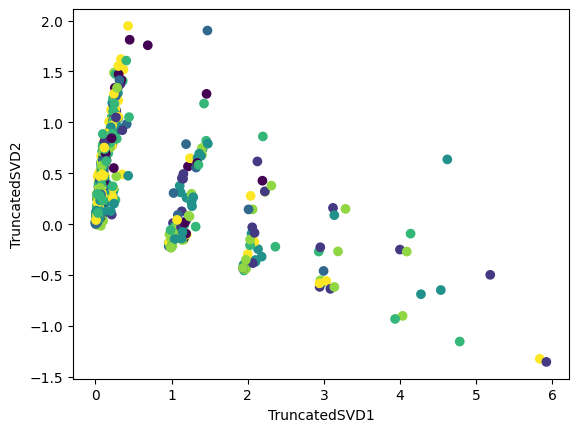

In [11]:
from sklearn.decomposition import PCA, TruncatedSVD


pca = TruncatedSVD(n_components=2)
X_pca = pca.fit_transform(X)

# Создать scatter plot основных компонентов [5](https://pythonhint.com/post/2226841201145928/basic-example-for-pca-with-matplotlib)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('TruncatedSVD1')
plt.ylabel('TruncatedSVD2')
plt.show()

In [12]:
pca = TruncatedSVD(n_components=2)
vectorizer = CountVectorizer()
label_encoder = LabelEncoder()



X = vectorizer.fit_transform(df_train['clean_text'])
X = pca.fit_transform(X)
y = label_encoder.fit_transform(df_train['category'])
clf = LogisticRegression().fit(X, y)

X_test = vectorizer.transform(df_test['clean_text'])
X_test = pca.transform(X_test)
y_test = label_encoder.transform(df_test['category'])

y_pred = clf.predict(X_test)
acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Accuracy: {acc:.3f}\nF1M: {f1:.3f}')

Accuracy: 0.260
F1M: 0.109


In [13]:
from sklearn.neural_network import MLPClassifier


vectorizer = CountVectorizer()
label_encoder = LabelEncoder()
X = vectorizer.fit_transform(df_train['clean_text'])
y = label_encoder.fit_transform(df_train['category'])
clf = MLPClassifier(alpha=0.001).fit(X, y)

X_test = vectorizer.transform(df_test['clean_text'])
y_test = label_encoder.transform(df_test['category'])

y_pred = clf.predict(X_test)
acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Accuracy: {acc:.3f}\nF1M: {f1:.3f}')

Accuracy: 0.696
F1M: 0.674


In [14]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 1))
scaler = StandardScaler(with_mean=False)

label_encoder = LabelEncoder()
# ????
# X = scaler.fit_transform(X)
X = vectorizer.fit_transform(df_train['clean_text'])
X = scaler.fit_transform(X)
print(f"TFIDF num features: {X.shape}", end='\n\n')

y = label_encoder.fit_transform(df_train['category'])


X_test = vectorizer.transform(df_test['clean_text'])
X_test = scaler.transform(X_test)
y_test = label_encoder.transform(df_test['category'])


clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X_test)
acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print('log reg, tfidf:')
print(f'Accuracy: {acc:.3f}\nF1M: {f1:.3f}', end='\n\n')

clf = MLPClassifier(alpha=0.001).fit(X, y)
y_pred = clf.predict(X_test)
acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print('mlp, tfidf:')
print(f'Accuracy: {acc:.3f}\nF1M: {f1:.3f}', end='\n\n')

TFIDF num features: (701, 4108)

log reg, tfidf:
Accuracy: 0.711
F1M: 0.694

mlp, tfidf:
Accuracy: 0.686
F1M: 0.664



In [15]:
from deeppavlov import build_model, configs

ranker = build_model(configs.doc_retrieval.ru_ranker_tfidf_wiki)

In [17]:
from sklearn.calibration import LabelEncoder
from sklearn.neural_network import MLPClassifier

label_encoder = LabelEncoder()
scaler = StandardScaler(with_mean=False)

X = ranker.batched_call(df_train['text'], batch_size=8)
X = scaler.fit_transform(X)
y = label_encoder.fit_transform(df_train['category'])
print("here1")

clf = MLPClassifier(alpha=0.001).fit(X, y)
del X
del y

X_test = ranker.batched_call(df_test['text'], batch_size=8)
X_test = scaler.transform(X_test)
y_test = label_encoder.fit_transform(df_test['category'])
print("here2")

y_pred = clf.predict(X_test)
acc = clf.score(X_test, y_test)

f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print('mlp, tfidf ru wiki:')
print(f'Accuracy: {acc:.3f}\nF1M: {f1:.3f}', end='\n\n')
del X_test
del y_test
del ranker

here1


/Users/antonadonin/PycharmProjects/nlp/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


here2
mlp, tfidf ru wiki:
Accuracy: 0.152
F1M: 0.123



In [24]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(ngram_range=(1, 1))
label_encoder = LabelEncoder()

X_train = vectorizer.fit_transform(df_train['clean_text'])
print(f"TFIDF num features: {X_train.shape}", end='\n\n')

y_train = label_encoder.fit_transform(df_train['category'])

X_val = vectorizer.transform(df_val['clean_text'])
y_val = label_encoder.transform(df_val['category'])

X_test = vectorizer.transform(df_test['clean_text'])
y_test = label_encoder.transform(df_test['category'])

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1, 
    depth=6,
    eval_metric='Accuracy',  
    random_seed=42
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

y_pred = model.predict(X_test)


acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f'Accuracy: {acc:.3f}\nF1M: {f1:.3f}')

TFIDF num features: (701, 4108)

Accuracy: 0.618
F1M: 0.603
